In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import rc
from scipy.special import expit

rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')

font = {'family' : 'monospace',
        'size'   : 24,
        'weight' : 'heavy'
       }

rc('font', **font)

%config InlineBackend.figure_formats = ['svg']

def plot_activations(xmin, xmax, ymin, ymax):
    text_size = 24
    legend_size = 20
    eps=0.2
    fig, ax = plt.subplots(figsize=(11, 6))
    xs = np.linspace(xmin, xmax, num=500)
    
    
    ax.spines['bottom'].set_position('zero')
    ax.spines['left'].set_position('zero')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    ax.text(xmax + eps, -.2, r"$x$", size=text_size)
    ax.text(0.1, ymax, r"$y$", size=text_size)
    
    arrow_fmt = dict(markersize=6, color='black', clip_on=False)
    ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
    ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)
    
    ax.plot(xs, expit(xs), c='r', lw=3, label= r'$\sigma(x) = \frac{1}{1+e^{-x}}$')
    ax.plot(xs, np.tanh(xs), c='orange', lw=3, label= r'$\tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}$')
    ax.plot(xs, np.maximum(0, xs), c='m', lw=3, label= r'$\mathrm{ReLU}(x) = x_+$')
    # plt.plot(xs, np.maximum(0.2*xs, xs), c='m', lw=3, label= r'$\mathrm{LReLU}(x)$')
    
    ax.plot([0, xmax], [1, 1], c='k', ls='--', lw=2)
    ax.plot([xmin, 0], [-1, -1], c='k', ls='--', lw=2)
    
    ax.text(-0.18, 0.05, r"0")
    
    ax.legend(fontsize=legend_size);
    ax.grid(ls=':')
    ax.set_xlim(xmin-eps, xmax+eps)
    ax.set_ylim(ymin - eps/2, ymax+eps/2)
    yticks = np.arange(ymin, ymax+1)
    xticks = np.arange(xmin, xmax+1)
    ax.set_yticks(yticks[yticks != 0]);
    ax.set_xticks(xticks[xticks != 0])
    ax.set_yticklabels(yticks[yticks != 0], size=legend_size)
    ax.set_xticklabels(xticks[xticks != 0], size=legend_size);

# Multilayer Perceptron (MLP)

In a nutshell, a neural network is a parametric function

$$
    F_{\boldsymbol \theta} \colon \mathbb R^{n_{\mathrm{in}}} \to \mathbb R^{n_{\mathrm{out}}}
$$
where
* $n_{\mathrm{in}}$ is the number of input features (e.g. $784$ for MNIST dataset)
* $n_{\mathrm{out}}$ is the number of output features (e.g. $1$ for binary classification or regression, $10$ for MNIST)
* $\boldsymbol \theta \in \mathbb R^{D}$ is a vector of learnable parameters

## Layers

<img src="https://res.cloudinary.com/practicaldev/image/fetch/s--2UPg0Z-6--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://imgur.com/KeIJEYy.jpeg">

More specifically, a neural network is a composition of **layers**:

$$
    F_{\boldsymbol \theta}(\boldsymbol x) = \big(f^{(L)}_{\boldsymbol \theta_L}  \circ \ldots \circ f^{(1)}_{\boldsymbol \theta_1}\big)(\boldsymbol x), \quad f^{(i)}_{\boldsymbol \theta_i}  \colon \mathbb R^{n_{i-1}} \to \mathbb R^{n_i}
$$

* $n_i$ is the size of $i$-th layer, $n_0 = n_{\mathrm{in}}$, $n_L = n_{\mathrm{out}}$
* $\boldsymbol \theta_i$ are parameters of $i$-th layer, $\boldsymbol \theta = (\boldsymbol \theta_1,\ldots, \boldsymbol \theta_L)$
* $\boldsymbol x_i = f^{(i)}_{\boldsymbol \theta_{i}}(\boldsymbol x_{i-1})$ is the representation of $i$-th layer, $\boldsymbol x_i \in \mathbb R^{n_i}$

### Hidden layers

* Input layer: $\boldsymbol x_0 = \boldsymbol x_{\mathrm{in}}$
* Output layer: $\boldsymbol x_L = \boldsymbol x_{\mathrm{out}} = f^{(L)}_{\boldsymbol \theta_L}(\boldsymbol x_{L-1})$
* Hidden layers: $\boldsymbol x_1,\ldots, \boldsymbol x_{L-1}$
* If $L=1$ there are no hidden layers

### Layers of MLP

<img src="https://www.researchgate.net/publication/339423202/figure/fig4/AS:868648621199363@1584113378612/Example-multilayer-perceptron-MLP-model-of-a-multi-classification-artificial-neural.png">

Each MLP layer looks like

$$
    \boldsymbol x_i = \psi_i(\boldsymbol x_{i-1} \boldsymbol W_{i} + \boldsymbol b_{i})
$$
where
* $\boldsymbol W_{i}$ is a matrix of the shape $n_{i-1}\times n_i$
* $\boldsymbol x_i, \boldsymbol b_i \in \mathbb R^{n_i}$ and $\boldsymbol x_{i-1} \in \mathbb R^{n_{i-1}}$ are **row-vectors**!
* $\psi_i(t)$ is an activation function which acts element-wise

**Q**. What is $\boldsymbol\theta_i$ in this notation of MLP layer?

Sometimes activatons are considered as single layers with no parameters. Then each layer of MLP splits into two:

* linear (dense) layer: $\boldsymbol z_i = \boldsymbol x_{i-1} \boldsymbol W^{(i)} + \boldsymbol b^{(i)}
$

* activation layer: $\quad \boldsymbol x_i = \psi_i(\boldsymbol z_{i})$

## Activations

The most popular **activation functions** (**nonlinearities**):
* sigmoid: $\sigma(x) = \frac 1{1+e^{-x}}$
* hyperbolic tangent: $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$
* Rectified Linear Unit: 
$$
\mathrm{ReLU}(x) = x_+ = \max\{x, 0\}
$$

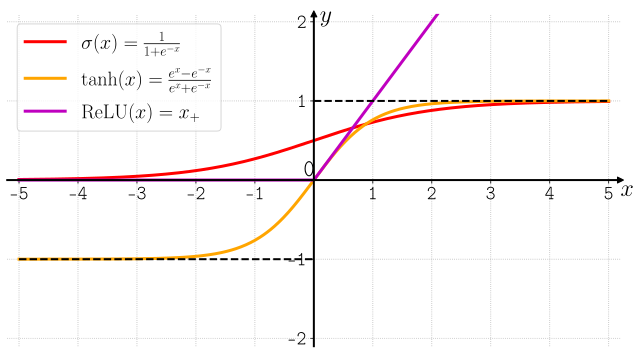

In [2]:
plot_activations(-5, 5, -2, 2)

## Learning objectives

### Binary classification

The output of the neural network is usually a number from $[0, 1]$ which is the probability of the positive class

Sigmoid is the typical choice for the output layer:
$$
\widehat y = x_L = x_{\mathrm{out}} = \sigma(x_{L-1})
$$

Loss function: $\mathcal L(\widehat y, y) = -y\log(\widehat y) -(1-y) \log(1-\widehat y)$

### Multilass classification

* For $K$ classes the output contains $K$ numbers $(\widehat y_1, \ldots, \widehat y_K)$
* $\widehat y_k$ is the probability of class $k$
* Now the output of the neural network is

$$
    \boldsymbol{\widehat y} = \boldsymbol x_L = \boldsymbol x_{\mathrm{out}} = \mathrm{SoftMax}(\boldsymbol x_{L-1}), 
$$

$$
    \mathrm{SoftMax}(\boldsymbol z)_i = \frac{e^{z_i}}{\sum_i
 e^{z_i}}$$

### Cross entropy loss

$$
\mathcal L(\boldsymbol{\widehat y}, \boldsymbol y) = -\sum\limits_{k=1}^K y_k\log(\widehat y_k)
$$

**Q**. Let $K=2$. Does this formula gives the same result as the loss function from binary classification? Why?

### Regression

Predict a real number $\widehat y = x_L = x_{\mathrm{out}}$

The loss function is usually quadratic: 

$$
\mathcal L(\widehat y, y) = (\widehat y - y)^2
$$

## Training of MLP

<img src="forward_pass.png">

**Q**. How many learnable parameters does this MLP have?

**A**. $\boldsymbol W_i$ has shape $n_{i-1}\times n_i$, $\boldsymbol b_i$ has length $n_i$, so...

The goal is to minimize the loss function with respect to parameters $\boldsymbol \theta$,

$$
\mathcal L = \mathcal L_{\boldsymbol\theta}(\boldsymbol {\widehat y}, \boldsymbol y) \to \min\limits_{\boldsymbol \theta}
$$

where
$$
\boldsymbol \theta = (\boldsymbol W_1, \boldsymbol b_1, \boldsymbol W_2, \boldsymbol b_2, \ldots, \boldsymbol W_L, \boldsymbol b_L)
$$

Let's use the standard technique — the gradient descent!

1. Start from some random parameters $\boldsymbol \theta_0$

2. Given a training sample $(\boldsymbol x, \boldsymbol y)$, do the **forward pass** and get the output $\boldsymbol {\widehat y} = F_{\boldsymbol \theta}(\boldsymbol x)$

3. Calculate the loss function
$\mathcal L_{\boldsymbol\theta}(\boldsymbol {\widehat y}, \boldsymbol y)$ and its gradient
$$
\nabla_{\boldsymbol\theta}\mathcal L_{\boldsymbol\theta}(\boldsymbol {\widehat y}, \boldsymbol y)
$$

4. Update the parameters:

$$
    \boldsymbol \theta = \boldsymbol \theta - \eta \nabla_{\boldsymbol\theta}\mathcal L_{\boldsymbol\theta}(\boldsymbol {\widehat y}, \boldsymbol y)
$$

5. Go to step 2 with next training sample

But how to calculate the gradients 

$$
\nabla_{\boldsymbol\theta}\mathcal L_{\boldsymbol\theta}(\boldsymbol {\widehat y}, \boldsymbol y)?
$$

The **error backpropagation** technique is used for this purpose.

## Batch training

It is compuationally inefficient to update all the parameters every time after passing a training sample

Instead, take a **batch** of size $B$ of training samples at a time and form the matrix
$\boldsymbol X_{\mathrm{in}}$ if the shape $B\times n_0$.

Now each hidden representation is a matrix of the shape $B \times n_i$:

$$
\boldsymbol X_i = \psi_i(\boldsymbol X_{i-1} \boldsymbol W_i +\boldsymbol B_i)
$$

The output also has $B$ rows. For instance, in the case of multiclassification task we have

$$
    \boldsymbol X_L = \boldsymbol {\widehat Y} \in \mathbb R^{B\times K},
$$

$$
    \mathcal L(\boldsymbol {\widehat Y}, \boldsymbol Y) = -\frac 1B\sum\limits_{i = 1}^B \sum\limits_{k=1}^K Y_{ik}\log(\widehat Y_{ik})
$$

## Back propagation

### Short summary

* Make the forward pass and calculate all hidden representations along with output and loss function:
$$
\boldsymbol X_1, \boldsymbol X_2, \ldots \boldsymbol X_{L-1}, \boldsymbol X_L = \boldsymbol{\widehat Y}, \mathcal L(\boldsymbol {\widehat Y}, \boldsymbol Y) 
$$
* Calculate the gradient of the loss function with respect to the output:
$$
\nabla_{\boldsymbol X_L} \mathcal L(\boldsymbol X_L, \boldsymbol Y) 
$$
* Make the **backward pass** from $\boldsymbol X_{L-1}$ to $\boldsymbol X_1$ and calculate $\nabla_{\boldsymbol X_i}\mathcal L$, $\nabla_{\boldsymbol W_i} \mathcal L$, $\nabla_{\boldsymbol B_i}\mathcal L$ on each step

### Backward pass through one layer

<img src="backprop.png">

## Practice time!

Implement your own MLP using [numpy](https://numpy.org/) and train it on MNIST!

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network. Recall that

$$
    \mathrm{ReLU}(x) = \max\{x, 0\},
$$

and the same rule works when $x$ is a vector or a matrix.

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # output = #YOUR CODE HERE
        return output
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        
        # Note that this is exactly the Hadamard product
        return grad_output*relu_grad     

In [5]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:

$$f(\boldsymbol X)= \boldsymbol X \boldsymbol W + \boldsymbol b $$

where 
* $\boldsymbol X$ is an object-feature matrix of shape [batch_size, num_features],
* $\boldsymbol W$ is a weight matrix [num_features, num_outputs] 
* and $\boldsymbol b$ is a vector of num_outputs biases.

Both $\boldsymbol X$ and $\boldsymbol b$ are initialized during layer creation and updated each time backward is called.

**Q**. What is the shape of $\boldsymbol X \boldsymbol W$? How can we add $\boldsymbol b$ to it?

**A**. Broadcasting!

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(X) = XW + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(X) = XW + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return #<your code here>
    
    def backward(self, input, grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output.dot(self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        # grad_weights = YOUR CODE HERE
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### Testing the dense layer

Here we have a few tests to make sure your dense layer works properly. You can just run them, get 3 "well done"s and forget they ever existed.

... or not get 3 "well done"s and go fix stuff. If that is the case, here are some tips for you:
* Make sure you compute gradients for W and b as __sum of gradients over batch__, not mean over gradients. Grad_output is already divided by batch size.
* If you're debugging, try saving gradients in class fields, like "self.grad_w = grad_w" or print first 3-5 weights. This helps debugging.
* If nothing else helps, try ignoring tests and proceed to network training. If it trains alright, you may be off by something that does not affect network training.

In [7]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [8]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [8]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

Go back to the cross entropy loss

$$
    \mathcal L(\boldsymbol {\widehat Y}, \boldsymbol Y) = -\frac 1B\sum\limits_{i = 1}^B \sum\limits_{k=1}^K Y_{ik}\log(\widehat Y_{ik})
$$

Here $\boldsymbol{\widehat Y} = \mathrm{SoftMax}(\boldsymbol X_{L-1})$ applied row-by-row. The output of previous layer $\boldsymbol X_{L-1}$ is called **logits**. Let's denote them $\boldsymbol A$, then

$$
   \mathcal L(\boldsymbol A, \boldsymbol Y) = -\frac 1B\sum\limits_{i = 1}^B \sum\limits_{k=1}^K Y_{ik}\log\bigg(\frac{e^{A_{ik}}}{\sum_k e^{A_{ik}}}\bigg) = \frac 1B\sum\limits_{i = 1}^B \bigg(-A_{i, \mathrm{true}} + \log {\sum_k e^{A_{ik}}}\bigg)
$$

The expression in brackets is called Log-softmax and it's better than naive log(softmax) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

Here you are! We've defined the both loss functions for you so that you could focus on neural network part.

In [9]:
def softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy from logits[batch, n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)), reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [10]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

### Full network

Now let's combine what we've just built into a working neural network. As we announced, we're gonna use this monster to classify handwritten digits, so let's get them loaded.

In [11]:
from sklearn.datasets import fetch_openml
X, Y = fetch_openml('mnist_784', return_X_y=True, parser='auto')
X = X.astype(float).values / 255
Y = Y.astype(int).values

In [12]:
def plot_digits(X, y_true, y_pred=None, n=4, random_state=123):
    np.random.seed(random_state)
    indices = np.random.choice(np.arange(X.shape[0]), size=n*n, replace=False)
    plt.figure(figsize=(10, 10))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        # plt.imshow(train_images[i], cmap=plt.cm.binary)
        if y_pred is None:
            title = str(y_true[indices[i]])
        else:
            title = f"y={y_true[indices[i]]}, ŷ={y_pred[indices[i]]}"
        plt.title(title, size=20)
    plt.show()

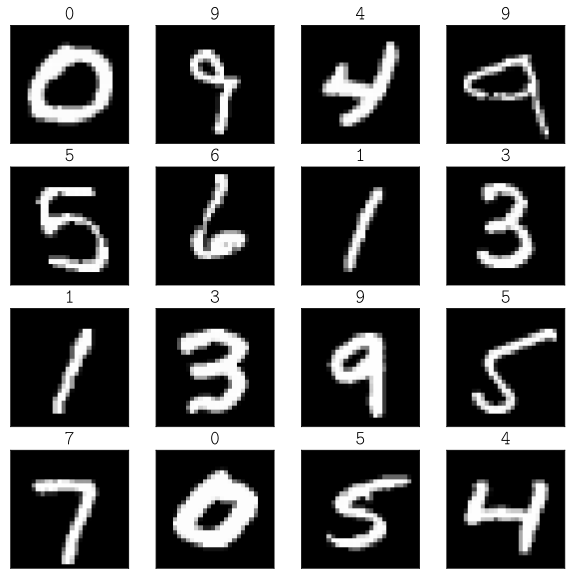

In [13]:
plot_digits(X, Y)

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=10000, random_state=42)
X_train, X_val = X_train[:-10000], X_train[-10000:]
y_train, y_val = y_train[:-10000], y_train[-10000:]
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (50000,), (10000,), (10000,))

We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [15]:
network = []
network.append(Dense(X_train.shape[1], 392))
network.append(ReLU())
network.append(Dense(392, 196))
network.append(ReLU())
network.append(Dense(196, 10))

In [16]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
        
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

### Backprop

You can now define the backpropagation step for the neural network. Please read the docstring.

In [17]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    
    
    for i in range(len(layer_inputs) - 2, -1, -1):
        loss_grad = network[i].backward(layer_inputs[i], loss_grad)

    return np.mean(loss)

Instead of tests, we provide you with a training loop that prints training and validation accuracies on every epoch.

If your implementation of forward and backward are correct, your accuracy should grow from 90~93% to >97% with the default network.

### Training loop

As usual, we split data into minibatches, feed each such minibatch into the network and update weights.

In [18]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9807


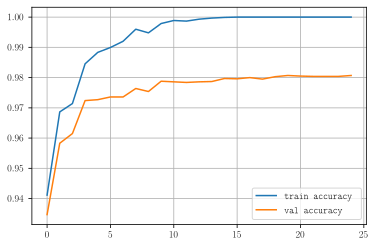

In [19]:
from IPython.display import clear_output
train_log = []
val_log = []

for epoch in range(25):

    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

In [20]:
np.mean(predict(network, X_test) == y_test)

0.9779

__What should you see:__ `train accuracy` should increase to near-100%. Val accuracy will also increase, allbeit to a smaller value.